In [1]:
import pandas as pd
import numpy as py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import json
import spacy
import collections

In [2]:
dataset  = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [3]:
    """
    Preprocessing of the headlines.
     * Word tokenization,
     * Lower case,
     * Stop word removal,
     * Punctuation removal,
     * Digit removal,
     * Lemmatization.
    """

'\nPreprocessing of the headlines.\n * Word tokenization,\n * Lower case,\n * Stop word removal,\n * Punctuation removal,\n * Digit removal,\n * Lemmatization.\n'

In [4]:
# Cleaning the text
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
corpus = []
nlp = spacy.load('en')
for i, headline in enumerate(dataset['headline']):
    doc = nlp(headline)
    review = dataset['headline'][i] 
    tokens = [word.lemma_.lower() for word in doc
        if len(word) > 3 and not (word.is_stop | word.is_punct | word.is_digit)]
    review = " ".join(tokens)
    #review = review.split() 
    #ps = SnowballStemmer("english")
    #review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    #review = ' '.join(review) 
    corpus.append(review) # add it to the corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\İREM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_model = SentimentIntensityAnalyzer()  

In [6]:
sentiments = []
for headline in corpus:
    scores = vader_model.polarity_scores(headline)
    #print()
    #print('INPUT SENTENCE', headline)
    #print('VADER OUTPUT', scores)
    scores_array = [scores['neg'],scores['neu'],scores['pos'],scores['compound']]
    sentiments.append(scores_array)

sentiment_array = np.array([np.array(x) for x in sentiments])

In [7]:
print((sentiment_array.shape))

(26709, 4)


In [9]:
# bag of words model
y = dataset.iloc[:, 2]
from sklearn.feature_extraction.text import TfidfVectorizer
features_n = range(2800, 3500, 100) # list of different max vectors to try
scores = []

for i in features_n:
    
    #Td-idf
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3),max_features = i)
    X = tf.fit_transform(corpus).toarray() #get the preprocessed text
    
    #add sentiment scores to feature vector
    X = np.concatenate((X,sentiment_array),axis=1)
   
    #Splitting
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
    
    #Logistic regression (our main model)
    from sklearn.linear_model import LogisticRegression  
    classifier = LogisticRegression(random_state=0, solver='lbfgs') 
    
    #Multinomial Naive Bayes (only for the last part)
    from sklearn.naive_bayes import MultinomialNB
    #classifier2 = MultinomialNB().fit(X_train, y_train)
    
    classifier.fit(X_train, y_train)
    #classifier2.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    #Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    error_rate = (FP+FN)/(TP+TN+FP+FN) # calculating the error rate based on confusion matrix results
    scores.append(error_rate)

C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Public\Empty\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Us

In [10]:
print(type(X.shape))

<class 'tuple'>


The optimal number of max vectors is 3400 with an error rate of 0.227


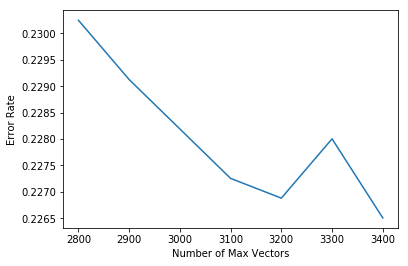

<Figure size 432x288 with 0 Axes>

In [11]:
#Printing out the optimal max features value and plot the results
optimal_n = features_n[scores.index(min(scores))]
print ("The optimal number of max vectors is %d" % optimal_n + " with an error rate of %.3f" % min(scores))
plt.plot(features_n, scores)
plt.xlabel('Number of Max Vectors')
plt.ylabel('Error Rate')
plt.show()
#plt.savefig('Sarcasm_Error')

In [12]:
print('Confusion matrix\n',confusion_matrix(y_test, y_pred))

Confusion matrix
 [[2554  453]
 [ 757 1578]]


In [13]:
print('Classification_report\n',classification_report(y_test, y_pred))

Classification_report
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      3007
           1       0.78      0.68      0.72      2335

   micro avg       0.77      0.77      0.77      5342
   macro avg       0.77      0.76      0.77      5342
weighted avg       0.77      0.77      0.77      5342



In [14]:
scores

[0.23025084238113067,
 0.2291276675402471,
 0.22819168850617746,
 0.22725570947210783,
 0.22688131785847998,
 0.22800449269936354,
 0.2265069262448521]

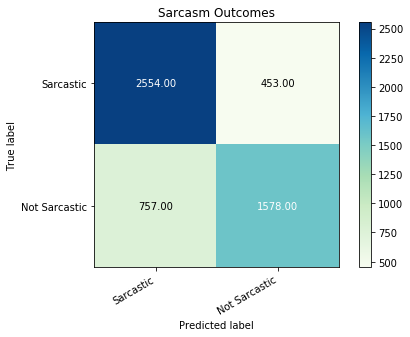

In [20]:
classes = ['Sarcastic','Not Sarcastic']
plt.rcParams["figure.figsize"] = (7,5)
normalize = True
cm =confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.GnBu)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title= "Sarcasm Outcomes",
       ylabel='True label',
       xlabel='Predicted label')
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.autofmt_xdate()
#plt.savefig('Sarcasm_Confusion_Matrix')

In [21]:
def important_features_per_class(vectorizer,classifier,n=80):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    print("Important words in non-sarcastic documents")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------")
    print("Important words in sarcastic documents")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat) 

In [26]:
#important_features_per_class(tf, classifier2)

In [24]:
feature_to_coef = {
    word: coef for word, coef in zip(
        tf.get_feature_names(), classifier.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
print("-----------------------------------------")

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)


('area', 6.909709904666131)
('nation', 5.411834751576067)
('report', 4.594138174006566)
('local', 4.219829079022231)
('introduce', 3.8964576537213262)
-----------------------------------------
('trump', -4.872319252326411)
('donald', -2.849819067296932)
('queer', -2.7641352454414467)
('way', -2.586171064096951)
('donald trump', -2.51269580756812)


In [15]:
"""
Content extraction from the headlines.
"""

'\nContent extraction from the headlines.\n'

In [16]:
from nltk.tokenize import word_tokenize
text_data = []
for sent in corpus:
    doc = word_tokenize(sent)
    text_data.append(doc)

In [17]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [18]:
import gensim
NUM_TOPICS = 30
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model1.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(12, '0.230*"trump" + 0.079*"donald" + 0.061*"house" + 0.051*"white"')
(19, '0.056*"open" + 0.046*"office" + 0.036*"teacher" + 0.032*"happen"')
(17, '0.115*"obama" + 0.064*"leave" + 0.027*"explain" + 0.022*"believe"')
(14, '0.063*"star" + 0.050*"girl" + 0.038*"force" + 0.030*"dead"')
(25, '0.044*"give" + 0.043*"self" + 0.031*"candidate" + 0.031*"couple"')
(0, '0.054*"work" + 0.046*"stop" + 0.029*"word" + 0.027*"father"')
(27, '0.063*"want" + 0.059*"come" + 0.050*"tell" + 0.045*"trump"')
(13, '0.049*"million" + 0.035*"food" + 0.030*"sign" + 0.027*"award"')
(28, '0.074*"know" + 0.061*"need" + 0.056*"kill" + 0.036*"bush"')
(1, '0.059*"plan" + 0.039*"fight" + 0.036*"baby" + 0.034*"announce"')
(16, '0.094*"good" + 0.071*"family" + 0.052*"friend" + 0.035*"movie"')
(2, '0.065*"like" + 0.063*"nation" + 0.062*"look" + 0.059*"thing"')
(23, '0.067*"clinton" + 0.045*"health" + 0.038*"hillary" + 0.034*"care"')
(29, '0.044*"fire" + 0.029*"employee" + 0.025*"tweet" + 0.025*"race"')
(7, '0.041*"hope" 

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model1.gensim')

import pyLDAvis.gensim 
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)